In [2]:
# developed from the following material, change dummy coding and outlier detection method 

# https://medium.com/towards-data-science/xgboost-for-multi-class-classification-799d96bcd368
# https://github.com/ernestng11/touchpoint-prediction/blob/master/data-cleaning_and_eda.ipynb
# data: https://github.com/ernestng11/touchpoint-prediction

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [20]:
df = pd.read_csv('./marketdata_clean.csv')

In [22]:
df.head()
# the index is read as 'Unnamed:0', need to drop it

,Unnamed: 0,age,income,aveSpend,touchpoints,nTouchpoints,touchpoint_emailDestination,touchpoint_emailDiscount,touchpoint_emailGift,touchpoint_mailDestination,...,SocialMedia_U,SocialMedia_Y,creditRating_A,creditRating_B,creditRating_C,creditRating_D,creditRating_E,creditRating_F,creditRating_G,creditRating_New
0,0,38,51000.0,5007.50,emailDestination mailDiscount,2,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,1,39,100000.0,19.74,emailDestination mailGift,2,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,2,41,51000.0,320.10,emailDiscount mailGift emailDiscount,3,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,60,152000.0,39.47,mailDiscount,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,4,47,60000.0,19.89,mailDestination emailDestination emailDestination,3,1,0,0,1,...,0,1,1,0,0,0,0,0,0,0


In [23]:
df = df.drop(columns = ['Unnamed: 0'])
# df = df.iloc[: , 1:]; this runs the data set only from the first column

In [24]:
df.sample()

,age,income,aveSpend,touchpoints,nTouchpoints,touchpoint_emailDestination,touchpoint_emailDiscount,touchpoint_emailGift,touchpoint_mailDestination,touchpoint_mailDiscount,...,SocialMedia_U,SocialMedia_Y,creditRating_A,creditRating_B,creditRating_C,creditRating_D,creditRating_E,creditRating_F,creditRating_G,creditRating_New
8636,41,100000.0,252.01,smsDiscount mailDiscount,2,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [25]:
df.shape

(12691, 32)

In [26]:
df.isnull().sum()

age                            0
income                         0
aveSpend                       0
touchpoints                    0
nTouchpoints                   0
touchpoint_emailDestination    0
touchpoint_emailDiscount       0
touchpoint_emailGift           0
touchpoint_mailDestination     0
touchpoint_mailDiscount        0
touchpoint_mailGift            0
touchpoint_smsDestination      0
touchpoint_smsDiscount         0
touchpoint_smsGift             0
marital_divorced               0
marital_married                0
marital_single                 0
segment_P1                     0
segment_P2                     0
segment_P3                     0
segment_P4                     0
SocialMedia_N                  0
SocialMedia_U                  0
SocialMedia_Y                  0
creditRating_A                 0
creditRating_B                 0
creditRating_C                 0
creditRating_D                 0
creditRating_E                 0
creditRating_F                 0
creditRati

In [32]:
'''
Kind of like a Pivot Table in that it groups data together by
different variable and subtotals (i.e., count, mean, standard deviation, etc.)
''' 
df.describe() 
# all numerical



,age,income,aveSpend,nTouchpoints,touchpoint_emailDestination,touchpoint_emailDiscount,touchpoint_emailGift,touchpoint_mailDestination,touchpoint_mailDiscount,touchpoint_mailGift,...,SocialMedia_U,SocialMedia_Y,creditRating_A,creditRating_B,creditRating_C,creditRating_D,creditRating_E,creditRating_F,creditRating_G,creditRating_New
count,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,...,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000,12691.000000
mean,39.205579,71754.864310,455.888371,2.973367,0.644709,0.423056,0.127177,0.108108,0.270585,0.103774,...,0.335119,0.334568,0.206997,0.251202,0.253408,0.136553,0.088645,0.028445,0.005201,0.029548
std,9.274208,36928.627863,1027.250661,2.136275,0.478620,0.494064,0.333184,0.310529,0.444280,0.304980,...,0.472051,0.471858,0.405169,0.433721,0.434980,0.343389,0.284243,0.166248,0.071930,0.169345
min,20.000000,10000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,45000.000000,19.770000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,64000.000000,88.750000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46.000000,90000.000000,383.730000,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,60.000000,249000.000000,7292.880000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Robust scaler 

In [33]:
# the 3 continuous variables' ranges vary significantly, so need to standardize the data

In [34]:
# Note that the max-min range of all 3 variables are very different from one another. 
# When we do further analysis, like multivariate linear regression, for example,
# the attributed income will intrinsically influence the result more due to its larger value. 
# Hence, it is important to standardize and normalize the data to bring all variables to the same range.
# 
# use Robust Scaler (QuantileTransformer): similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.

In [35]:

qt = QuantileTransformer(output_distribution='normal')

In [36]:
df['nAveSpend'] = qt.fit_transform(df[['aveSpend']].values.reshape(-1,1))
df['nIncome'] = qt.fit_transform(df[['income']].values.reshape(-1,1))
df['nAge'] = qt.fit_transform(df[['age']].values.reshape(-1,1))

In [37]:
df[['nAveSpend','nIncome','nAge']].describe() 
# of similar range now
# Note that this function greatly compresses the range from -20 min and 60 max to -5.199 min and 5.199 max

,nAveSpend,nIncome,nAge
count,12691.000000,12691.000000,12691.000000
mean,-0.013194,-0.000090,0.015339
std,1.065121,1.002134,1.079264
min,-5.199338,-5.199338,-5.199338
25%,-0.676002,-0.695908,-0.654930
50%,0.000635,-0.002509,0.038901
75%,0.674226,0.689529,0.668987
max,5.199338,5.199338,5.199338


Plot for NAGE: total counts = 12691


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-38-5a23e94f9b3c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


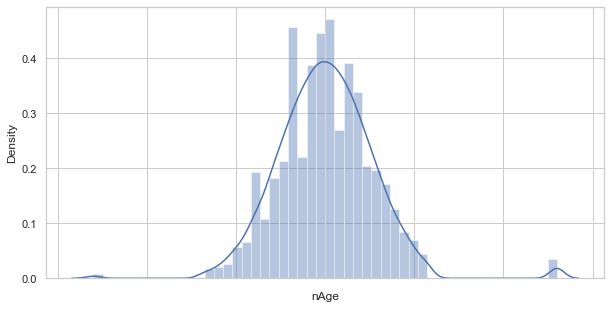

Plot for NINCOME: total counts = 12691


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-38-5a23e94f9b3c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


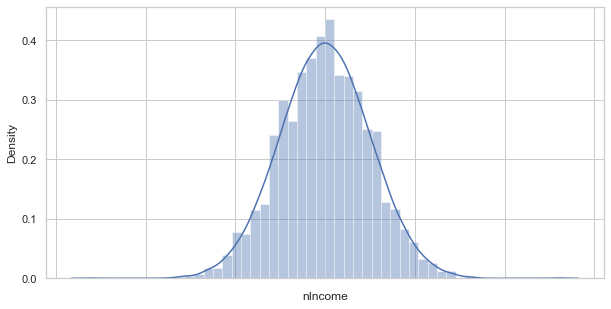

Plot for NAVESPEND: total counts = 12691


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-38-5a23e94f9b3c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


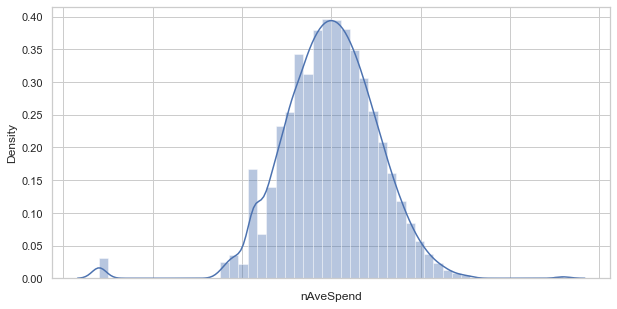

In [38]:

sns.set(style="whitegrid")

df_explore = df[['nAge', 'nIncome', 'nAveSpend']]
for cat in df_explore:
    cat_num = df_explore[cat]
    print("Plot for %s: total counts = %d" % (cat.upper(), len(cat_num)))
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.distplot(cat_num)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    plt.show() # all look good

# create target var

In [39]:
# assume the last touchpoint in the column is the most current one
# the results indicate that email is the most common touchpoint, 
# suggesting that emails are the best method for the company to secure sales.
df.touchpoints.value_counts()

emailDestination                                                                                 2053
emailDiscount                                                                                     826
mailDiscount                                                                                      405
emailDestination emailDestination                                                                 345
smsDiscount                                                                                       337
                                                                                                 ... 
smsDiscount mailDestination emailDestination                                                        1
emailDiscount emailDestination emailDiscount smsGift smsDiscount emailDiscount emailDiscount        1
emailDestination emailDiscount smsDiscount emailDestination emailDestination emailDestination       1
emailDestination mailDiscount smsGift emailDiscount emailDiscount                 

In [42]:
df.touchpoints.head()

0                        emailDestination mailDiscount
1                            emailDestination mailGift
2                 emailDiscount mailGift emailDiscount
3                                         mailDiscount
4    mailDestination emailDestination emailDestination
Name: touchpoints, dtype: object

In [49]:
# use reverse split by delimiter 
# This function takes the last substring [which resembles a word separated by white space from the previous "word"]
# and divides it
# df1 = df["touchpoints"].str.split(" ", n = 1, expand = True) 
df['last_touchpoint'] = df['touchpoints'].str.split(' ').str[-1]


In [52]:
df[['touchpoints']].head(10)

,touchpoints
0,emailDestination mailDiscount
1,emailDestination mailGift
2,emailDiscount mailGift emailDiscount
3,mailDiscount
4,mailDestination emailDestination emailDestination
5,emailDestination
6,smsDiscount
7,emailDestination emailDiscount
8,emailDestination mailDiscount emailGift emailD...
9,emailDiscount mailDiscount


In [53]:
# df1.head()
df[['last_touchpoint']].head(10)

,last_touchpoint
0,mailDiscount
1,mailGift
2,emailDiscount
3,mailDiscount
4,emailDestination
5,emailDestination
6,smsDiscount
7,emailDiscount
8,emailDestination
9,mailDiscount


In [54]:
df.last_touchpoint.value_counts()

emailDestination    4708
emailDiscount       2767
mailDiscount        1529
smsDiscount          994
emailGift            591
mailDestination      568
mailGift             561
smsGift              518
smsDestination       455
Name: last_touchpoint, dtype: int64

In [55]:
# recode it as numerical values 
dic = {'emailDestination': 1, 
'emailDiscount'   :     2,
'mailDiscount'    :    3, 
'smsDiscount'      :   4,
'emailGift'         :  5,
'smsDestination'    :  6,
'smsGift'           :  7,
'mailDestination':  8,
'mailGift'          :  9}

In [56]:
# maps the new value to the newly created column
df['label'] = df['last_touchpoint'].map(dic)

In [57]:
df.label.value_counts()

1    4708
2    2767
3    1529
4     994
5     591
8     568
9     561
7     518
6     455
Name: label, dtype: int64

In [58]:
df.sample() # so the label show up as the last column, numeric

,age,income,aveSpend,touchpoints,nTouchpoints,touchpoint_emailDestination,touchpoint_emailDiscount,touchpoint_emailGift,touchpoint_mailDestination,touchpoint_mailDiscount,...,creditRating_D,creditRating_E,creditRating_F,creditRating_G,creditRating_New,nAveSpend,nIncome,nAge,last_touchpoint,label
11262,47,72000.0,102.24,mailDestination,1,0,0,0,1,0,...,0,1,0,0,0,0.07954,0.262686,0.754664,mailDestination,8


# defind x, y for modeling

In [59]:
# stratified split -- define function

In [60]:
def stratified_split(df, target, val_percent=0.2):
    '''
    Function to split a dataframe into train and validation sets, while preserving the ratio of the labels in the target variable
    Inputs:
    - df, the dataframe
    - target, the target variable
    - val_percent, the percentage of validation samples, default 0.2
    Outputs:
    - train_idxs, the indices of the training dataset
    - val_idxs, the indices of the validation dataset
    '''
    classes=list(df[target].unique())
    train_idxs, val_idxs = [], []
    for c in classes:
        idx=list(df[df[target]==c].index)
        np.random.shuffle(idx)
        val_size=int(len(idx)*val_percent)
        val_idxs+=idx[:val_size]
        train_idxs+=idx[val_size:]
    return train_idxs, val_idxs


train_idxs, val_idxs = stratified_split(df, 'label', val_percent=0.25)

val_idxs, test_idxs = stratified_split(df[df.index.isin(val_idxs)], 'label', val_percent=0.5)

In [61]:
def test_stratified(df, col):
    '''
    Analyzes the ratio of different classes in a categorical variable within a dataframe
    Inputs:
    - dataframe
    - categorical column to be analyzed
    Returns: None
    '''
    classes=list(df[col].unique())
    
    for c in classes:
        print(f'Proportion of records with {c}: {len(df[df[col]==c])*1./len(df):0.2} ({len(df[df[col]==c])} / {len(df)})')

In [62]:
print('---------- STRATIFIED SAMPLING REPORT ----------')
print('-------- Label proportions in FULL data --------')
test_stratified(df, 'label')
print('-------- Label proportions in TRAIN data --------')
test_stratified(df[df.index.isin(train_idxs)], 'label')
print('------ Label proportions in VALIDATION data -----')
test_stratified(df[df.index.isin(val_idxs)], 'label')
print('-------- Label proportions in TEST data ---------')
test_stratified(df[df.index.isin(test_idxs)], 'label')

---------- STRATIFIED SAMPLING REPORT ----------
-------- Label proportions in FULL data --------
Proportion of records with 3: 0.12 (1529 / 12691)
Proportion of records with 9: 0.044 (561 / 12691)
Proportion of records with 2: 0.22 (2767 / 12691)
Proportion of records with 1: 0.37 (4708 / 12691)
Proportion of records with 4: 0.078 (994 / 12691)
Proportion of records with 6: 0.036 (455 / 12691)
Proportion of records with 5: 0.047 (591 / 12691)
Proportion of records with 7: 0.041 (518 / 12691)
Proportion of records with 8: 0.045 (568 / 12691)
-------- Label proportions in TRAIN data --------
Proportion of records with 9: 0.044 (421 / 9522)
Proportion of records with 2: 0.22 (2076 / 9522)
Proportion of records with 3: 0.12 (1147 / 9522)
Proportion of records with 1: 0.37 (3531 / 9522)
Proportion of records with 4: 0.078 (746 / 9522)
Proportion of records with 6: 0.036 (342 / 9522)
Proportion of records with 5: 0.047 (444 / 9522)
Proportion of records with 7: 0.041 (389 / 9522)
Proportion

In [63]:
df.columns

Index(['age', 'income', 'aveSpend', 'touchpoints', 'nTouchpoints',
       'touchpoint_emailDestination', 'touchpoint_emailDiscount',
       'touchpoint_emailGift', 'touchpoint_mailDestination',
       'touchpoint_mailDiscount', 'touchpoint_mailGift',
       'touchpoint_smsDestination', 'touchpoint_smsDiscount',
       'touchpoint_smsGift', 'marital_divorced', 'marital_married',
       'marital_single', 'segment_P1', 'segment_P2', 'segment_P3',
       'segment_P4', 'SocialMedia_N', 'SocialMedia_U', 'SocialMedia_Y',
       'creditRating_A', 'creditRating_B', 'creditRating_C', 'creditRating_D',
       'creditRating_E', 'creditRating_F', 'creditRating_G',
       'creditRating_New', 'nAveSpend', 'nIncome', 'nAge', 'last_touchpoint',
       'label'],
      dtype='object')

In [64]:
df_select = df[['label',
                'nTouchpoints',
                'touchpoint_emailDestination', 
                'touchpoint_emailDiscount',
                'touchpoint_emailGift', 
                'touchpoint_mailDestination',
                'touchpoint_mailDiscount', 
                'touchpoint_mailGift',
                'touchpoint_smsDestination', 
                'touchpoint_smsDiscount',
                'touchpoint_smsGift', 
                'marital_divorced', 
                'marital_married',
                'marital_single', 
                'segment_P1', 
                'segment_P2', 
                'segment_P3',
                'segment_P4', 
                'SocialMedia_N', 
                'SocialMedia_U', 
                'SocialMedia_Y',
                'creditRating_A', 
                'creditRating_B', 
                'creditRating_C', 
                'creditRating_D',
                'creditRating_E', 
                'creditRating_F', 
                'creditRating_G',
                'creditRating_New', 
                'nAveSpend', 
                'nIncome', 
                'nAge'
                ]]

In [65]:
train_df = df_select[df_select.index.isin(train_idxs)]

X_train =  train_df.drop('label',axis=1).values

Y_train = train_df[['label']].values
print('Retrieved Training Data')

Retrieved Training Data


In [66]:
val_df = df_select[df_select.index.isin(val_idxs)]

X_val = val_df.drop('label',axis=1).values

Y_val = val_df[['label']].values
print('Retrieved Validation Data')

Retrieved Validation Data


In [67]:
test_df = df_select[df_select.index.isin(test_idxs)]
X_test = test_df.drop('label',axis=1).values
Y_test = test_df[['label']].values
print('Retrieved Test Data')

Retrieved Test Data


# modeling

In [68]:
# store data, all in numpy arrays. 
training_data = {'X_train':X_train,'Y_train':Y_train,
                 'X_val': X_val,   'Y_val':Y_val,
                 'X_test': X_test, 'Y_test':Y_test}

In [69]:
training_data

{'X_train': array([[ 2.        ,  1.        ,  0.        , ..., -0.67843252,
          0.90518882,  0.12199509],
        [ 3.        ,  0.        ,  1.        , ...,  0.59512592,
         -0.40880512,  0.28352193],
        [ 1.        ,  0.        ,  0.        , ..., -0.35187273,
          1.83177799,  5.19933758],
        ...,
        [ 6.        ,  1.        ,  1.        , ...,  1.38462826,
         -0.05397265,  1.26966439],
        [ 4.        ,  1.        ,  0.        , ...,  1.94270301,
         -0.76135267, -0.98357337],
        [ 2.        ,  1.        ,  0.        , ...,  0.8306756 ,
          0.04392402,  0.03890144]]),
 'Y_train': array([[9],
        [2],
        [3],
        ...,
        [3],
        [3],
        [3]], dtype=int64),
 'X_val': array([[ 2.        ,  1.        ,  0.        , ...,  2.13226643,
         -0.40880512,  0.03890144],
        [ 2.        ,  0.        ,  1.        , ...,  0.28091085,
          0.28054545, -0.98357337],
        [ 1.        ,  1.       

## baseline model -- random forest

In [70]:
clf = RandomForestClassifier(n_jobs=None,random_state=27,
                       verbose=1)
clf.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


RandomForestClassifier(random_state=27, verbose=1)

In [71]:
predicted_labels = clf.predict(training_data['X_test'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [72]:
accuracy_score(training_data['Y_test'], predicted_labels)

0.9608091024020228

### tunning parameters

In [73]:
params = {
    'n_estimators'      : range(100,500,50),
    'max_depth'         : [8, 9, 10, 11, 12],
    'max_features': ['auto'],
    'criterion' :['gini']
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = clf, param_grid = params, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    2.6s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [8, 9, 10, 11, 12],
                         'max_features': ['auto'],
                         'n_estimators': range(100, 500, 50)},
             scoring='f1_micro', verbose=10)

In [74]:
# based on gridsearchCV
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [75]:
getTrainScores(gsearch1)

({0: "mean:0.7965752442709368params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}",
  1: "mean:0.796049813626238params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 150}",
  2: "mean:0.796785659145548params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}",
  3: "mean:0.7955252652241999params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 250}",
  4: "mean:0.7965752442709367params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 300}",
  5: "mean:0.797100785195968params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 350}",
  6: "mean:0.7963659321996516params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 400}",
  7: "mean:0.7973109795099141params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 450}",
  8: "mean:0.8317566554180728params{'criter

In [76]:
clf2 = gsearch1.best_estimator_
''' {'best_mean': 0.9039915966386555,
  'best_param': {'criterion': 'gini',
   'max_depth': 12,
   'max_features': 'auto',
   'n_estimators': 450}})'''

params1 = {
    'n_estimators'      : range(300,450,50),
    'max_depth'         : [11, 12,13]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch2 = GridSearchCV(estimator = clf2, param_grid = params1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch2.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.8s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=12, n_estimators=450,
                                              random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [11, 12, 13],
                         'n_estimators': range(300, 450, 50)},
             scoring='f1_micro', verbose=10)

In [77]:
getTrainScores(gsearch2)

({0: "mean:0.8899396215178985params{'max_depth': 11, 'n_estimators': 300}",
  1: "mean:0.8899392906769007params{'max_depth': 11, 'n_estimators': 350}",
  2: "mean:0.8913046163347229params{'max_depth': 11, 'n_estimators': 400}",
  3: "mean:0.90684796753347params{'max_depth': 12, 'n_estimators': 300}",
  4: "mean:0.9075829859502855params{'max_depth': 12, 'n_estimators': 350}",
  5: "mean:0.9074779439334788params{'max_depth': 12, 'n_estimators': 400}",
  6: "mean:0.9215505414764331params{'max_depth': 13, 'n_estimators': 300}",
  7: "mean:0.9213404574428197params{'max_depth': 13, 'n_estimators': 350}",
  8: "mean:0.9214454994596263params{'max_depth': 13, 'n_estimators': 400}"},
 {'best_mean': 0.9215505414764331,
  'best_param': {'max_depth': 13, 'n_estimators': 300}})

In [78]:
clf3 = gsearch2.best_estimator_ # best depth 13, n_est = 300

params2 = {
    'n_estimators'      : range(200,300,20),
    'max_depth'         : [12,13,14]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch3 = GridSearchCV(estimator = clf3, param_grid = params2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch3.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    1.9s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=13, n_estimators=300,
                                              random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [12, 13, 14],
                         'n_estimators': range(200, 300, 20)},
             scoring='f1_micro', verbose=10)

In [79]:
getTrainScores(gsearch3)

({0: "mean:0.9069524581486137params{'max_depth': 12, 'n_estimators': 200}",
  1: "mean:0.9071629281633913params{'max_depth': 12, 'n_estimators': 220}",
  2: "mean:0.9054826418756479params{'max_depth': 12, 'n_estimators': 240}",
  3: "mean:0.9056923950682634params{'max_depth': 12, 'n_estimators': 260}",
  4: "mean:0.9070579964269172params{'max_depth': 12, 'n_estimators': 280}",
  5: "mean:0.9208153576391187params{'max_depth': 13, 'n_estimators': 200}",
  6: "mean:0.9209203445157591params{'max_depth': 13, 'n_estimators': 220}",
  7: "mean:0.921025607093231params{'max_depth': 13, 'n_estimators': 240}",
  8: "mean:0.9216555834932398params{'max_depth': 13, 'n_estimators': 260}",
  9: "mean:0.9215504863362668params{'max_depth': 13, 'n_estimators': 280}",
  10: "mean:0.9270115132667239params{'max_depth': 14, 'n_estimators': 200}",
  11: "mean:0.9275366682105914params{'max_depth': 14, 'n_estimators': 220}",
  12: "mean:0.9272214318798386params{'max_depth': 14, 'n_estimators': 240}",
  13: "mea

In [80]:
clf4 = gsearch3.best_estimator_ # gsearch3 best: depth 14, n 280, 

params3 = {
    'n_estimators'      : range(200,280,5),
    'max_depth'         : range(14,20,1),
    
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch4 = GridSearchCV(estimator = clf4, param_grid = params3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch4.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    2.0s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=14, n_estimators=280,
                                              random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': range(14, 20),
                         'n_estimators': range(200, 280, 5)},
             scoring='f1_micro', verbose=10)

In [81]:
getTrainScores(gsearch4)

({0: "mean:0.9270115132667239params{'max_depth': 14, 'n_estimators': 200}",
  1: "mean:0.9278518494011777params{'max_depth': 14, 'n_estimators': 205}",
  2: "mean:0.9283768940647125params{'max_depth': 14, 'n_estimators': 210}",
  3: "mean:0.9279567259974856params{'max_depth': 14, 'n_estimators': 215}",
  4: "mean:0.9275366682105914params{'max_depth': 14, 'n_estimators': 220}",
  5: "mean:0.9275364476499262params{'max_depth': 14, 'n_estimators': 225}",
  6: "mean:0.9273265290368116params{'max_depth': 14, 'n_estimators': 230}",
  7: "mean:0.927221542160171params{'max_depth': 14, 'n_estimators': 235}",
  8: "mean:0.9272214318798386params{'max_depth': 14, 'n_estimators': 240}",
  9: "mean:0.9270113478462252params{'max_depth': 14, 'n_estimators': 245}",
  10: "mean:0.9280614923134609params{'max_depth': 14, 'n_estimators': 250}",
  11: "mean:0.9277462008425417params{'max_depth': 14, 'n_estimators': 255}",
  12: "mean:0.9276414345265666params{'max_depth': 14, 'n_estimators': 260}",
  13: "mea

In [84]:
clf5 = gsearch4.best_estimator_ # 

params4 = {
    'n_estimators'       : range(200,270,10) ,
    'max_depth'         : range(18,22,1)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch5 = GridSearchCV(estimator = clf5, param_grid = params4, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch5.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    2.1s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=18, n_estimators=270,
                                              random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': range(18, 22),
                         'n_estimators': range(200, 270, 10)},
             scoring='f1_micro', verbose=10)

In [85]:
getTrainScores(gsearch5)

({0: "mean:0.9408743576170625params{'max_depth': 18, 'n_estimators': 200}",
  1: "mean:0.9423448355720241params{'max_depth': 18, 'n_estimators': 210}",
  2: "mean:0.9427646727982533params{'max_depth': 18, 'n_estimators': 220}",
  3: "mean:0.9429747568318666params{'max_depth': 18, 'n_estimators': 230}",
  4: "mean:0.9426595205011139params{'max_depth': 18, 'n_estimators': 240}",
  5: "mean:0.9426597962019454params{'max_depth': 18, 'n_estimators': 250}",
  6: "mean:0.9429747016917004params{'max_depth': 18, 'n_estimators': 260}",
  7: "mean:0.9410846622113412params{'max_depth': 19, 'n_estimators': 200}",
  8: "mean:0.9409795650543682params{'max_depth': 19, 'n_estimators': 210}",
  9: "mean:0.9411894836674828params{'max_depth': 19, 'n_estimators': 220}",
  10: "mean:0.9409795650543682params{'max_depth': 19, 'n_estimators': 230}",
  11: "mean:0.9409795650543682params{'max_depth': 19, 'n_estimators': 240}",
  12: "mean:0.9417146937515163params{'max_depth': 19, 'n_estimators': 250}",
  13: "me

In [86]:
clf6 = gsearch5.best_estimator_ #  best depth18

params5 = {
    'n_estimators'      : range(190,260,10),
    'max_depth'         : range(21,28,1)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch6 = GridSearchCV(estimator = clf6, param_grid = params5, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch6.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    1.8s finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=21, n_estimators=260,
                                              random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': range(21, 28),
                         'n_estimators': range(190, 260, 10)},
             scoring='f1_micro', verbose=10)

In [87]:
getTrainScores(gsearch6)

({0: "mean:0.943814265863826params{'max_depth': 21, 'n_estimators': 190}",
  1: "mean:0.9441292264937472params{'max_depth': 21, 'n_estimators': 200}",
  2: "mean:0.9442344339310527params{'max_depth': 21, 'n_estimators': 210}",
  3: "mean:0.944129226493747params{'max_depth': 21, 'n_estimators': 220}",
  4: "mean:0.9443393105273605params{'max_depth': 21, 'n_estimators': 230}",
  5: "mean:0.9437093892675179params{'max_depth': 21, 'n_estimators': 240}",
  6: "mean:0.9440243498974393params{'max_depth': 21, 'n_estimators': 250}",
  7: "mean:0.9416094311740444params{'max_depth': 22, 'n_estimators': 190}",
  8: "mean:0.9429745914113677params{'max_depth': 22, 'n_estimators': 200}",
  9: "mean:0.9429745914113677params{'max_depth': 22, 'n_estimators': 210}",
  10: "mean:0.9428694942543947params{'max_depth': 22, 'n_estimators': 220}",
  11: "mean:0.9434995809347362params{'max_depth': 22, 'n_estimators': 230}",
  12: "mean:0.9439196387216302params{'max_depth': 22, 'n_estimators': 240}",
  13: "mean

In [88]:
clf7 = gsearch6.best_estimator_ #  best depth18

params6 = {
    'n_estimators'      : range(160,230,10),
    'max_depth'         : range(23,30,1)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch7 = GridSearchCV(estimator = clf7, param_grid = params6, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch7.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch7)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    1.5s finished


({0: "mean:0.9452845232581222params{'max_depth': 23, 'n_estimators': 160}",
  1: "mean:0.9457047464655153params{'max_depth': 23, 'n_estimators': 170}",
  2: "mean:0.9445493945609739params{'max_depth': 23, 'n_estimators': 180}",
  3: "mean:0.9439193630207988params{'max_depth': 23, 'n_estimators': 190}",
  4: "mean:0.9447593683142548params{'max_depth': 23, 'n_estimators': 200}",
  5: "mean:0.9447592580339222params{'max_depth': 23, 'n_estimators': 210}",
  6: "mean:0.9445492291404751params{'max_depth': 23, 'n_estimators': 220}",
  7: "mean:0.9437093341273517params{'max_depth': 24, 'n_estimators': 160}",
  8: "mean:0.9439196938617969params{'max_depth': 24, 'n_estimators': 170}",
  9: "mean:0.9437093341273517params{'max_depth': 24, 'n_estimators': 180}",
  10: "mean:0.9433943734974305params{'max_depth': 24, 'n_estimators': 190}",
  11: "mean:0.944444848805664params{'max_depth': 24, 'n_estimators': 200}",
  12: "mean:0.9441297227552438params{'max_depth': 24, 'n_estimators': 210}",
  13: "mea

In [89]:
clf8 = gsearch7.best_estimator_ #  best depth18

params7 = {
    'n_estimators'      : range(100,170,10),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch8 = GridSearchCV(estimator = clf8, param_grid = params7, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch8.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch8)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    1.3s finished


({0: "mean:0.9422394075740534params{'n_estimators': 100}",
  1: "mean:0.9430796885683407params{'n_estimators': 110}",
  2: "mean:0.9434995257945697params{'n_estimators': 120}",
  3: "mean:0.9436046229515428params{'n_estimators': 130}",
  4: "mean:0.9439198592822956params{'n_estimators': 140}",
  5: "mean:0.9442345993515516params{'n_estimators': 150}",
  6: "mean:0.9452845232581222params{'n_estimators': 160}"},
 {'best_mean': 0.9452845232581222, 'best_param': {'n_estimators': 160}})

In [90]:
clf9 = gsearch8.best_estimator_ #  best depth18

params8 = {
    'n_estimators'      : range(90,160,10),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch9 = GridSearchCV(estimator = clf9, param_grid = params8, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch9.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch9)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.4s finished


({0: "mean:0.9415043340170713params{'n_estimators': 90}",
  1: "mean:0.9422394075740534params{'n_estimators': 100}",
  2: "mean:0.9430796885683407params{'n_estimators': 110}",
  3: "mean:0.9434995257945697params{'n_estimators': 120}",
  4: "mean:0.9436046229515428params{'n_estimators': 130}",
  5: "mean:0.9439198592822956params{'n_estimators': 140}",
  6: "mean:0.9442345993515516params{'n_estimators': 150}"},
 {'best_mean': 0.9442345993515516, 'best_param': {'n_estimators': 150}})

In [91]:
clf10 = gsearch9.best_estimator_ #  best depth18

params9 = {
    'n_estimators'      : range(80,150,5),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch10 = GridSearchCV(estimator = clf10, param_grid = params9, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch10.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch10)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:    1.2s finished


({0: "mean:0.9400343523236065params{'n_estimators': 80}",
  1: "mean:0.9416093760338782params{'n_estimators': 85}",
  2: "mean:0.9415043340170713params{'n_estimators': 90}",
  3: "mean:0.9426594653609476params{'n_estimators': 95}",
  4: "mean:0.9422394075740534params{'n_estimators': 100}",
  5: "mean:0.9427644522375879params{'n_estimators': 105}",
  6: "mean:0.9430796885683407params{'n_estimators': 110}",
  7: "mean:0.9431845651646485params{'n_estimators': 115}",
  8: "mean:0.9434995257945697params{'n_estimators': 120}",
  9: "mean:0.943604457531044params{'n_estimators': 125}",
  10: "mean:0.9436046229515428params{'n_estimators': 130}",
  11: "mean:0.9443397516486909params{'n_estimators': 135}",
  12: "mean:0.9439198592822956params{'n_estimators': 140}",
  13: "mean:0.9430794128675093params{'n_estimators': 145}"},
 {'best_mean': 0.9443397516486909, 'best_param': {'n_estimators': 135}})

In [92]:
clf11 = gsearch10.best_estimator_ #  best depth18

params10 = {
    'n_estimators'      : range(65,135,5),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch11 = GridSearchCV(estimator = clf11, param_grid = params10, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch11.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch11)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    1.1s finished


({0: "mean:0.9394041553629325params{'n_estimators': 65}",
  1: "mean:0.9403493680936942params{'n_estimators': 70}",
  2: "mean:0.9408744127572289params{'n_estimators': 75}",
  3: "mean:0.9400343523236065params{'n_estimators': 80}",
  4: "mean:0.9416093760338782params{'n_estimators': 85}",
  5: "mean:0.9415043340170713params{'n_estimators': 90}",
  6: "mean:0.9426594653609476params{'n_estimators': 95}",
  7: "mean:0.9422394075740534params{'n_estimators': 100}",
  8: "mean:0.9427644522375879params{'n_estimators': 105}",
  9: "mean:0.9430796885683407params{'n_estimators': 110}",
  10: "mean:0.9431845651646485params{'n_estimators': 115}",
  11: "mean:0.9434995257945697params{'n_estimators': 120}",
  12: "mean:0.943604457531044params{'n_estimators': 125}",
  13: "mean:0.9436046229515428params{'n_estimators': 130}"},
 {'best_mean': 0.9436046229515428, 'best_param': {'n_estimators': 130}})

In [93]:
clf12 = gsearch11.best_estimator_ #  best depth18

params11 = {
    'n_estimators'      : range(65,130,5),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch12 = GridSearchCV(estimator = clf12, param_grid = params11, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch12.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch12)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    1.1s finished


({0: "mean:0.9394041553629325params{'n_estimators': 65}",
  1: "mean:0.9403493680936942params{'n_estimators': 70}",
  2: "mean:0.9408744127572289params{'n_estimators': 75}",
  3: "mean:0.9400343523236065params{'n_estimators': 80}",
  4: "mean:0.9416093760338782params{'n_estimators': 85}",
  5: "mean:0.9415043340170713params{'n_estimators': 90}",
  6: "mean:0.9426594653609476params{'n_estimators': 95}",
  7: "mean:0.9422394075740534params{'n_estimators': 100}",
  8: "mean:0.9427644522375879params{'n_estimators': 105}",
  9: "mean:0.9430796885683407params{'n_estimators': 110}",
  10: "mean:0.9431845651646485params{'n_estimators': 115}",
  11: "mean:0.9434995257945697params{'n_estimators': 120}",
  12: "mean:0.943604457531044params{'n_estimators': 125}"},
 {'best_mean': 0.943604457531044, 'best_param': {'n_estimators': 125}})

In [94]:
clf13 = gsearch12.best_estimator_ #  best depth18

params12 = {
    'n_estimators'      : range(65,125,5),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch13 = GridSearchCV(estimator = clf13, param_grid = params12, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch13.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch13)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.1s finished


({0: "mean:0.9394041553629325params{'n_estimators': 65}",
  1: "mean:0.9403493680936942params{'n_estimators': 70}",
  2: "mean:0.9408744127572289params{'n_estimators': 75}",
  3: "mean:0.9400343523236065params{'n_estimators': 80}",
  4: "mean:0.9416093760338782params{'n_estimators': 85}",
  5: "mean:0.9415043340170713params{'n_estimators': 90}",
  6: "mean:0.9426594653609476params{'n_estimators': 95}",
  7: "mean:0.9422394075740534params{'n_estimators': 100}",
  8: "mean:0.9427644522375879params{'n_estimators': 105}",
  9: "mean:0.9430796885683407params{'n_estimators': 110}",
  10: "mean:0.9431845651646485params{'n_estimators': 115}",
  11: "mean:0.9434995257945697params{'n_estimators': 120}"},
 {'best_mean': 0.9434995257945697, 'best_param': {'n_estimators': 120}})

In [95]:
clf14 = gsearch13.best_estimator_ #  best depth18

params13 = {
    'n_estimators'      : range(65,120,5),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch14 = GridSearchCV(estimator = clf14, param_grid = params13, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch14.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch14)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    1.4s finished


({0: "mean:0.9394041553629325params{'n_estimators': 65}",
  1: "mean:0.9403493680936942params{'n_estimators': 70}",
  2: "mean:0.9408744127572289params{'n_estimators': 75}",
  3: "mean:0.9400343523236065params{'n_estimators': 80}",
  4: "mean:0.9416093760338782params{'n_estimators': 85}",
  5: "mean:0.9415043340170713params{'n_estimators': 90}",
  6: "mean:0.9426594653609476params{'n_estimators': 95}",
  7: "mean:0.9422394075740534params{'n_estimators': 100}",
  8: "mean:0.9427644522375879params{'n_estimators': 105}",
  9: "mean:0.9430796885683407params{'n_estimators': 110}",
  10: "mean:0.9431845651646485params{'n_estimators': 115}"},
 {'best_mean': 0.9431845651646485, 'best_param': {'n_estimators': 115}})

In [96]:
clf15 = gsearch14.best_estimator_ #  best depth18

params14 = {
    'n_estimators'      : range(65,115,5),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch15 = GridSearchCV(estimator = clf15, param_grid = params14, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch15.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch15)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.0s finished


({0: "mean:0.9394041553629325params{'n_estimators': 65}",
  1: "mean:0.9403493680936942params{'n_estimators': 70}",
  2: "mean:0.9408744127572289params{'n_estimators': 75}",
  3: "mean:0.9400343523236065params{'n_estimators': 80}",
  4: "mean:0.9416093760338782params{'n_estimators': 85}",
  5: "mean:0.9415043340170713params{'n_estimators': 90}",
  6: "mean:0.9426594653609476params{'n_estimators': 95}",
  7: "mean:0.9422394075740534params{'n_estimators': 100}",
  8: "mean:0.9427644522375879params{'n_estimators': 105}",
  9: "mean:0.9430796885683407params{'n_estimators': 110}"},
 {'best_mean': 0.9430796885683407, 'best_param': {'n_estimators': 110}})

In [97]:
clf16 = gsearch15.best_estimator_ #  best depth18

params15 = {
    'n_estimators'      : range(65,110,5),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch16 = GridSearchCV(estimator = clf16, param_grid = params15, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch16.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch16)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    1.1s finished


({0: "mean:0.9394041553629325params{'n_estimators': 65}",
  1: "mean:0.9403493680936942params{'n_estimators': 70}",
  2: "mean:0.9408744127572289params{'n_estimators': 75}",
  3: "mean:0.9400343523236065params{'n_estimators': 80}",
  4: "mean:0.9416093760338782params{'n_estimators': 85}",
  5: "mean:0.9415043340170713params{'n_estimators': 90}",
  6: "mean:0.9426594653609476params{'n_estimators': 95}",
  7: "mean:0.9422394075740534params{'n_estimators': 100}",
  8: "mean:0.9427644522375879params{'n_estimators': 105}"},
 {'best_mean': 0.9427644522375879, 'best_param': {'n_estimators': 105}})

In [98]:
clf17 = gsearch16.best_estimator_ #  best depth18

params16 = {
    'n_estimators'      : range(65,105,2),
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch17 = GridSearchCV(estimator = clf17, param_grid = params16, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch17.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))

getTrainScores(gsearch17)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.9s finished


({0: "mean:0.9394041553629325params{'n_estimators': 65}",
  1: "mean:0.9398239925891616params{'n_estimators': 67}",
  2: "mean:0.9398239925891616params{'n_estimators': 69}",
  3: "mean:0.9392991133461258params{'n_estimators': 71}",
  4: "mean:0.9403493680936942params{'n_estimators': 73}",
  5: "mean:0.9408744127572289params{'n_estimators': 75}",
  6: "mean:0.9406647147047795params{'n_estimators': 77}",
  7: "mean:0.9403494232338604params{'n_estimators': 79}",
  8: "mean:0.9412944705441232params{'n_estimators': 81}",
  9: "mean:0.9418195152076578params{'n_estimators': 83}",
  10: "mean:0.9416093760338782params{'n_estimators': 85}",
  11: "mean:0.9412943602637907params{'n_estimators': 87}",
  12: "mean:0.9417144731908511params{'n_estimators': 89}",
  13: "mean:0.942449381327334params{'n_estimators': 91}",
  14: "mean:0.9429747016917004params{'n_estimators': 93}",
  15: "mean:0.9426594653609476params{'n_estimators': 95}",
  16: "mean:0.9428693288338957params{'n_estimators': 97}",
  17: "m

In [99]:
# best depth still at 18, so this is final!! 

final_clf = gsearch17.best_estimator_

In [100]:
final_clf.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))
predicted_labels = final_clf.predict(training_data['X_test'])
train_pred = final_clf.predict(training_data['X_train'])
print('Train Accuracy:'+str(accuracy_score(training_data['Y_train'], train_pred)))
print('Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='micro')))
print('Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='macro')))
print('Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='weighted')))



print('------')
print('Test Accuracy:'+str(accuracy_score(training_data['Y_test'], predicted_labels)))
print('Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='micro')))
print('Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='macro')))
print('Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='weighted')))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train Accuracy:1.0
Train F1-Score(Micro):1.0
Train F1-Score(Micro):1.0
Train F1-Score(Micro):1.0
------
Test Accuracy:0.9627054361567636
Test F1-Score(Micro):0.9627054361567636
Test F1-Score(Micro):0.9664213078843787
Test F1-Score(Micro):0.9627070099815368


[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.1s finished


## the F1-score reaches 0.95 for test, 1 for Train --- overfitting? !!!!--- use some controls in xgboost

In [101]:
df_select.columns

Index(['label', 'nTouchpoints', 'touchpoint_emailDestination',
       'touchpoint_emailDiscount', 'touchpoint_emailGift',
       'touchpoint_mailDestination', 'touchpoint_mailDiscount',
       'touchpoint_mailGift', 'touchpoint_smsDestination',
       'touchpoint_smsDiscount', 'touchpoint_smsGift', 'marital_divorced',
       'marital_married', 'marital_single', 'segment_P1', 'segment_P2',
       'segment_P3', 'segment_P4', 'SocialMedia_N', 'SocialMedia_U',
       'SocialMedia_Y', 'creditRating_A', 'creditRating_B', 'creditRating_C',
       'creditRating_D', 'creditRating_E', 'creditRating_F', 'creditRating_G',
       'creditRating_New', 'nAveSpend', 'nIncome', 'nAge'],
      dtype='object')

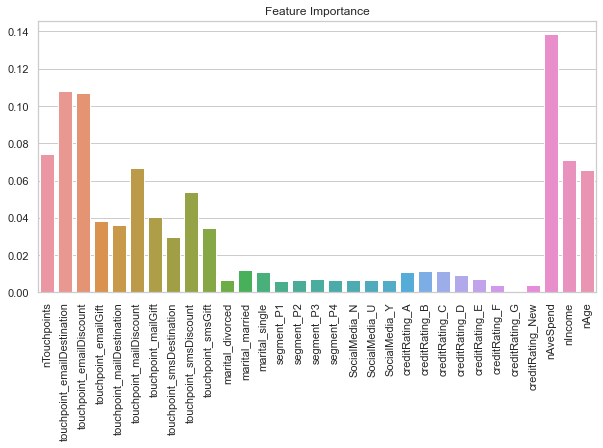

In [102]:
f, ax = plt.subplots(figsize=(10,5))
features = ['nTouchpoints', 'touchpoint_emailDestination',
       'touchpoint_emailDiscount', 'touchpoint_emailGift',
       'touchpoint_mailDestination', 'touchpoint_mailDiscount',
       'touchpoint_mailGift', 'touchpoint_smsDestination',
       'touchpoint_smsDiscount', 'touchpoint_smsGift', 'marital_divorced',
       'marital_married', 'marital_single', 'segment_P1', 'segment_P2',
       'segment_P3', 'segment_P4', 'SocialMedia_N', 'SocialMedia_U',
       'SocialMedia_Y', 'creditRating_A', 'creditRating_B', 'creditRating_C',
       'creditRating_D', 'creditRating_E', 'creditRating_F', 'creditRating_G',
       'creditRating_New', 'nAveSpend', 'nIncome', 'nAge']

plot = sns.barplot(x=features, y=final_clf.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

# marital, creditrating, and socialmedia have relatively low importance! 

## xgboost 

In [103]:
#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()

In [104]:
def fitXgb(sk_model, training_data=training_data,epochs=300):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['Y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['Y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,  evals_result=store, verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['Y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['Y_test'],average='micro')))
    plot_compare(metrics,store,epochs)
    features = ['nTouchpoints', 'touchpoint_emailDestination',
       'touchpoint_emailDiscount', 'touchpoint_emailGift',
       'touchpoint_mailDestination', 'touchpoint_mailDiscount',
       'touchpoint_mailGift', 'touchpoint_smsDestination',
       'touchpoint_smsDiscount', 'touchpoint_smsGift', 'marital_divorced',
       'marital_married', 'marital_single', 'segment_P1', 'segment_P2',
       'segment_P3', 'segment_P4', 'SocialMedia_N', 'SocialMedia_U',
       'SocialMedia_Y', 'creditRating_A', 'creditRating_B', 'creditRating_C',
       'creditRating_D', 'creditRating_E', 'creditRating_F', 'creditRating_G',
       'creditRating_New', 'nAveSpend', 'nIncome', 'nAge']
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

## xgb and hyperparameter tuning 

In [105]:
# # parameter explaination
# reference: https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

# learning_rate: usually between 0.1 and 0.01. If you’re focused on performance and have enough time, decrease incrementally the learning rate while increasing the number of trees.
# n_estimators: 100 if the size of your data is high, 1000 is if it is medium-low
# max_depth: the maximum number of different features used in each tree.suggest start with low numbers, then change 1 each time, stop when no performance gains 
# subsample: 0.8,which is for each tree the % of rows taken to build the tree. I recommend not taking out too many rows, as performance will drop a lot. 
# colsample_bytree: take out some col for each tree to avoid overfitting. use Values from 0.3 to 0.8 if you have many columns (especially if you did one-hot encoding), or 0.8 to 1 if you only have a few columns.
# gamma: 1. acts as a regularization parameter. Either 0, 1 or 5.



In [106]:
 
#initial model
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000, # start with 100 if dataset is large, use 1000 for small-mid sized data
                    max_depth=5, 
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',  # this is the obj for multi-classificaiton
                    nthread=4,
                    num_class=9, # need to specify num 
                    seed=27)

In [107]:
# use early stopping to avoid over fitting
# reference: 
# https://mljar.com/blog/xgboost-early-stopping/
# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

xgb1.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],), 
         eval_set=[(X_train, Y_train), (X_val, Y_val)], 
         early_stopping_rounds=20)


results = xgb1.evals_result()





E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:46:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.95238	validation_1-mlogloss:1.95659
[1]	validation_0-mlogloss:1.75579	validation_1-mlogloss:1.76390
[2]	validation_0-mlogloss:1.60838	validation_1-mlogloss:1.61831
[3]	validation_0-mlogloss:1.48398	validation_1-mlogloss:1.49621
[4]	validation_0-mlogloss:1.38854	validation_1-mlogloss:1.40301


E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[5]	validation_0-mlogloss:1.29791	validation_1-mlogloss:1.31554
[6]	validation_0-mlogloss:1.23198	validation_1-mlogloss:1.25315
[7]	validation_0-mlogloss:1.15664	validation_1-mlogloss:1.17907
[8]	validation_0-mlogloss:1.10018	validation_1-mlogloss:1.12441
[9]	validation_0-mlogloss:1.05377	validation_1-mlogloss:1.08041
[10]	validation_0-mlogloss:1.00002	validation_1-mlogloss:1.02851
[11]	validation_0-mlogloss:0.95835	validation_1-mlogloss:0.98916
[12]	validation_0-mlogloss:0.91444	validation_1-mlogloss:0.94819
[13]	validation_0-mlogloss:0.87879	validation_1-mlogloss:0.91334
[14]	validation_0-mlogloss:0.84260	validation_1-mlogloss:0.87796
[15]	validation_0-mlogloss:0.80913	validation_1-mlogloss:0.84595
[16]	validation_0-mlogloss:0.77945	validation_1-mlogloss:0.81731
[17]	validation_0-mlogloss:0.75184	validation_1-mlogloss:0.79126
[18]	validation_0-mlogloss:0.72369	validation_1-mlogloss:0.76403
[19]	validation_0-mlogloss:0.70056	validation_1-mlogloss:0.74163
[20]	validation_0-mlogloss:0.6

KeyError: 'merror'

<Figure size 720x504 with 0 Axes>

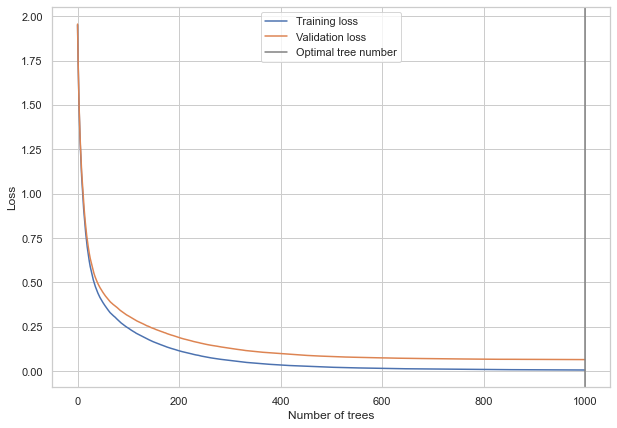

In [110]:
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
plt.axvline(xgb1.best_ntree_limit , color="gray", label="Optimal tree number") # need to use different function 
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# both lines have downslope, so sign of overfitting 

In [111]:
xgb1.best_ntree_limit 

1000

In [112]:
# evaluate the original xgb model, 0.96, slightly higher than random forest

In [113]:
predicted_labels = xgb1.predict(training_data['X_test'])
train_pred = xgb1.predict(training_data['X_train'], ntree_limit= xgb1.best_ntree_limit) # use the above best n tree
print('xgb1 Train Accuracy:'+str(accuracy_score(training_data['Y_train'], train_pred)))
print('xgb1 Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='micro')))
print('------')
print('xgb1 Test Accuracy:'+str(accuracy_score(training_data['Y_test'], predicted_labels)))
print('xgb1 Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='micro')))

E:\Anaconda\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


xgb1 Train Accuracy:1.0
xgb1 Train F1-Score(Micro):1.0
------
xgb1 Test Accuracy:0.984197218710493
xgb1 Test F1-Score(Micro):0.984197218710493


## fine tunning

In [114]:
params = {
    'n_estimators'      : range(100,500,100),
    'max_depth'         : range(5,10,1),
    'min_child_weight':range(1,6,2)
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = xgb1, param_grid = params, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, Y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[22:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=1000, n_jobs=4, nthread=4,
                                     num_class=9, num_parallel_tree=1,
                                     objective='multi:softprob',
                                     predictor='auto', random_state=27,
                                     reg_alpha=0, reg_lambda

In [115]:
getTrainScores(gsearch1)

({0: "mean:0.9091570171375636params{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}",
  1: "mean:0.9470697412823397params{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}",
  2: "mean:0.9566265246255983params{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}",
  3: "mean:0.9599874280420829params{'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 400}",
  4: "mean:0.9017006881492755params{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100}",
  5: "mean:0.9373024879243035params{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200}",
  6: "mean:0.9498001720373189params{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300}",
  7: "mean:0.955681201614504params{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 400}",
  8: "mean:0.8950846401552747params{'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}",
  9: "mean:0.9304762456163568params{'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200}",
  10: "mean:0.9433939

In [116]:
xgb2 = gsearch1.best_estimator_ # {'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300}})

param_xgb2 = {
    'max_depth'      : [8,9,10],
    'n_estimators': range(100, 300, 100),
    'min_child_weight' : [1,3]
}

gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_xgb2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch2.fit(X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[22:39:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=300, n_jobs=4, nthread=4,
                                     num_class=9, num_parallel_tree=1,
                                     objective='multi:softprob',
                                     predictor='auto', random_state=27,
                                     reg_alpha=0, reg_lambda=

In [117]:
getTrainScores(gsearch2)

({0: "mean:0.934257508926696params{'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100}",
  1: "mean:0.9400336063852132params{'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200}",
  2: "mean:0.9272211720226843params{'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 100}",
  3: "mean:0.93803822726318params{'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 200}",
  4: "mean:0.9394034866624658params{'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100}",
  5: "mean:0.9431842049989498params{'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200}",
  6: "mean:0.9332073093887838params{'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 100}",
  7: "mean:0.9427641251837849params{'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 200}",
  8: "mean:0.9410838059231255params{'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100}",
  9: "mean:0.9440243646292795params{'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200}",
  10: "mean:0.9350976

In [118]:
xgb3 = gsearch2.best_estimator_ #best depth 8, n 200, weight seems stable at 1 now 

param_xgb3 = {
    'max_depth': range(8,14,1),
    'n_estimators': range(100, 200, 10)}

gsearch3 = GridSearchCV(estimator = xgb3, param_grid = param_xgb3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch3.fit(X_train, Y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[23:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=200, n_jobs=4, nthread=4,
                                     num_class=9, num_parallel_tree=1,
                                     objective='multi:softprob',
                                     predictor='auto', random_state=27,
                                     reg_alpha=0, reg_lambda

In [119]:
getTrainScores(gsearch3)

({0: "mean:0.934257508926696params{'max_depth': 8, 'n_estimators': 100}",
  1: "mean:0.9357277882797731params{'max_depth': 8, 'n_estimators': 110}",
  2: "mean:0.9369880277252678params{'max_depth': 8, 'n_estimators': 120}",
  3: "mean:0.937513127494224params{'max_depth': 8, 'n_estimators': 130}",
  4: "mean:0.9376181474480152params{'max_depth': 8, 'n_estimators': 140}",
  5: "mean:0.9384583070783448params{'max_depth': 8, 'n_estimators': 150}",
  6: "mean:0.9392984667086747params{'max_depth': 8, 'n_estimators': 160}",
  7: "mean:0.9391934467548834params{'max_depth': 8, 'n_estimators': 170}",
  8: "mean:0.9391934467548834params{'max_depth': 8, 'n_estimators': 180}",
  9: "mean:0.9396135265700482params{'max_depth': 8, 'n_estimators': 190}",
  10: "mean:0.9394034866624658params{'max_depth': 9, 'n_estimators': 100}",
  11: "mean:0.9405587061541693params{'max_depth': 9, 'n_estimators': 110}",
  12: "mean:0.9406637261079606params{'max_depth': 9, 'n_estimators': 120}",
  13: "mean:0.9416089056

In [120]:
xgb4 = gsearch3.best_estimator_ #best depth 11, n 110, weight seems stable at 1 now 

param_xgb4 = {
    'max_depth': range(10,14,1),
    'n_estimators': range(50,110,10)}

gsearch4 = GridSearchCV(estimator = xgb4, param_grid = param_xgb4, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch4.fit(X_train, Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[23:10:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=0,
                                     gpu_id=-1, importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=11, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=110, n_jobs=4, nthread=4,
                                     num_class=9, num_parallel_tree=1,
                                     objective='multi:softprob',
                                     predictor='auto', random_state=27,
                                     reg_alpha=0, reg_lambda

In [121]:
getTrainScores(gsearch4)

({0: "mean:0.9325771896660365params{'max_depth': 10, 'n_estimators': 50}",
  1: "mean:0.9362528880487293params{'max_depth': 10, 'n_estimators': 60}",
  2: "mean:0.9375131274942238params{'max_depth': 10, 'n_estimators': 70}",
  3: "mean:0.9392984667086747params{'max_depth': 10, 'n_estimators': 80}",
  4: "mean:0.9407687460617518params{'max_depth': 10, 'n_estimators': 90}",
  5: "mean:0.9410838059231255params{'max_depth': 10, 'n_estimators': 100}",
  6: "mean:0.93803822726318params{'max_depth': 11, 'n_estimators': 50}",
  7: "mean:0.9401386263390044params{'max_depth': 11, 'n_estimators': 60}",
  8: "mean:0.941398865784499params{'max_depth': 11, 'n_estimators': 70}",
  9: "mean:0.9429741650913673params{'max_depth': 11, 'n_estimators': 80}",
  10: "mean:0.9441293845830708params{'max_depth': 11, 'n_estimators': 90}",
  11: "mean:0.9436042848141147params{'max_depth': 11, 'n_estimators': 100}",
  12: "mean:0.9407687460617516params{'max_depth': 12, 'n_estimators': 50}",
  13: "mean:0.941503885

In [122]:
xgb5 = gsearch4.best_estimator_ #best depth 15, n 200,

param_xgb5 = {
    'n_estimators': range(50,90,5)}

gsearch5 = GridSearchCV(estimator = xgb5, param_grid = param_xgb5, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch5.fit(X_train, Y_train)

getTrainScores(gsearch5)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[23:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({0: "mean:0.93803822726318params{'n_estimators': 50}",
  1: "mean:0.9384583070783449params{'n_estimators': 55}",
  2: "mean:0.9401386263390044params{'n_estimators': 60}",
  3: "mean:0.9407687460617516params{'n_estimators': 65}",
  4: "mean:0.941398865784499params{'n_estimators': 70}",
  5: "mean:0.9420289855072465params{'n_estimators': 75}",
  6: "mean:0.9429741650913673params{'n_estimators': 80}",
  7: "mean:0.9440243646292795params{'n_estimators': 85}"},
 {'best_mean': 0.9440243646292795, 'best_param': {'n_estimators': 85}})

In [123]:
xgb5 = gsearch4.best_estimator_ # 'best_param': {'n_estimators': 85}})

param_xgb5 = {
    'n_estimators': range(75,85,1)}

gsearch5 = GridSearchCV(estimator = xgb5, param_grid = param_xgb5, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch5.fit(X_train, Y_train)

getTrainScores(gsearch5)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[23:26:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({0: "mean:0.9420289855072465params{'n_estimators': 75}",
  1: "mean:0.9422390254148288params{'n_estimators': 76}",
  2: "mean:0.9424490653224114params{'n_estimators': 77}",
  3: "mean:0.9429741650913673params{'n_estimators': 78}",
  4: "mean:0.9429741650913673params{'n_estimators': 79}",
  5: "mean:0.9429741650913673params{'n_estimators': 80}",
  6: "mean:0.9433942449065323params{'n_estimators': 81}",
  7: "mean:0.9438143247216971params{'n_estimators': 82}",
  8: "mean:0.9434992648603234params{'n_estimators': 83}",
  9: "mean:0.9444444444444445params{'n_estimators': 84}"},
 {'best_mean': 0.9444444444444445, 'best_param': {'n_estimators': 84}})

In [125]:
xgb6 = gsearch5.best_estimator_ # 'best_param': {'n_estimators': 85}})

param_xgb6 = {
    'n_estimators': range(80,85,1)}

gsearch6 = GridSearchCV(estimator = xgb6, param_grid = param_xgb6, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch6.fit(X_train, Y_train)

getTrainScores(gsearch6)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


E:\Anaconda\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[23:32:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({0: "mean:0.9429741650913673params{'n_estimators': 80}",
  1: "mean:0.9433942449065323params{'n_estimators': 81}",
  2: "mean:0.9438143247216971params{'n_estimators': 82}",
  3: "mean:0.9434992648603234params{'n_estimators': 83}",
  4: "mean:0.9444444444444445params{'n_estimators': 84}"},
 {'best_mean': 0.9444444444444445, 'best_param': {'n_estimators': 84}})

[23:33:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb Train Accuracy:1.0
xgb Train F1-Score(Micro):1.0
xgb Train F1-Score(weighted):1.0
------
xgb Test Accuracy:0.9829329962073325
xgb Test F1-Score(Micro):0.9829329962073325
xgb Test F1-Score(weighted):0.9829108063954028


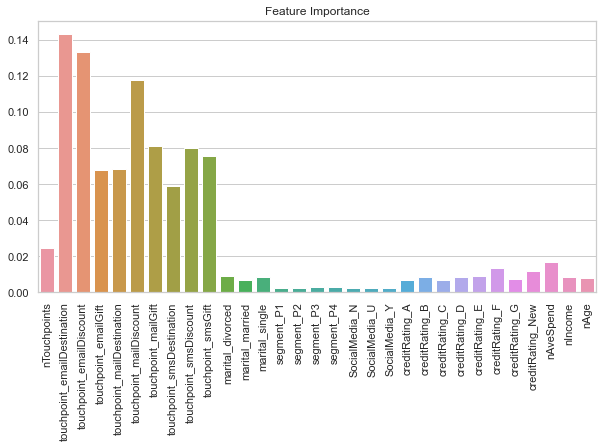

In [126]:
final_xgb = gsearch6.best_estimator_
final_xgb.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],))
predicted_labels = final_xgb.predict(training_data['X_test'])

train_pred = final_xgb.predict(training_data['X_train'])

print('xgb Train Accuracy:'+str(accuracy_score(training_data['Y_train'], train_pred)))
print('xgb Train F1-Score(Micro):'+str(f1_score(training_data['Y_train'], train_pred,average='micro')))
print('xgb Train F1-Score(weighted):'+str(f1_score(training_data['Y_train'], train_pred,average='weighted')))
print('------')
print('xgb Test Accuracy:'+str(accuracy_score(training_data['Y_test'], predicted_labels)))
print('xgb Test F1-Score(Micro):'+str(f1_score(training_data['Y_test'], predicted_labels,average='micro')))
print('xgb Test F1-Score(weighted):'+str(f1_score(training_data['Y_test'], predicted_labels,average='weighted')))

f, ax = plt.subplots(figsize=(10,5))
features = ['nTouchpoints', 'touchpoint_emailDestination',
       'touchpoint_emailDiscount', 'touchpoint_emailGift',
       'touchpoint_mailDestination', 'touchpoint_mailDiscount',
       'touchpoint_mailGift', 'touchpoint_smsDestination',
       'touchpoint_smsDiscount', 'touchpoint_smsGift', 'marital_divorced',
       'marital_married', 'marital_single', 'segment_P1', 'segment_P2',
       'segment_P3', 'segment_P4', 'SocialMedia_N', 'SocialMedia_U',
       'SocialMedia_Y', 'creditRating_A', 'creditRating_B', 'creditRating_C',
       'creditRating_D', 'creditRating_E', 'creditRating_F', 'creditRating_G',
       'creditRating_New', 'nAveSpend', 'nIncome', 'nAge']

plot = sns.barplot(x=features, y=final_xgb.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

# segment has the lowest weights
# marital, creditrating, and socialmedia have relatively low importance! 
# see way higher weights on touchpoints

# slightly higher in test accuracy and f1-score

In [127]:
df_select.label.value_counts()

1    4708
2    2767
3    1529
4     994
5     591
8     568
9     561
7     518
6     455
Name: label, dtype: int64

In [128]:
df_select.label.isnull().sum()

0

In [133]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]

final_xgb.fit(training_data['X_train'], training_data['Y_train'].reshape(training_data['Y_train'].shape[0],),
             eval_set= eval_set)

# make predictions for test data
train_pred = final_xgb.predict(X_test)
predictions = [round(value) for value in train_pred]

# retrieve performance metrics
results = final_xgb.evals_result()



[23:44:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.90088	validation_1-mlogloss:1.91631
[1]	validation_0-mlogloss:1.67033	validation_1-mlogloss:1.69987
[2]	validation_0-mlogloss:1.49195	validation_1-mlogloss:1.52911
[3]	validation_0-mlogloss:1.34094	validation_1-mlogloss:1.38435
[4]	validation_0-mlogloss:1.22269	validation_1-mlogloss:1.27308
[5]	validation_0-mlogloss:1.11782	validation_1-mlogloss:1.17158
[6]	validation_0-mlogloss:1.02824	validation_1-mlogloss:1.08693
[7]	validation_0-mlogloss:0.94235	validation_1-mlogloss:1.00436
[8]	validation_0-mlogloss:0.86917	validation_1-mlogloss:0.93534
[9]	validation_0-mlogloss:0.80702	validation_1-mlogloss:0.87729
[10]	validation_0-mlogloss:0.74687	validation_1-m

In [138]:
import matplotlib.pyplot as plt

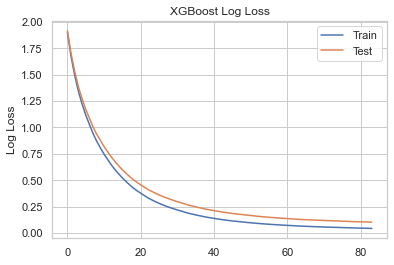

In [143]:
epochs = len(results['validation_0']['mlogloss'])
# WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'.
# Explicitly set eval_metric if you'd like to restore the old behavior.

x_axis = range(0, epochs)

# plot log loss
 

fig, ax = plt.subplots()
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


In [ ]:
# model deploy 

In [ ]:
import pickle

pickl = {'model': final_xgb}
pickle.dump(pickl, open('model_file'+'.p','wb'))

In [ ]:
file_name = 'model_file.p'
with open(file_name,'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [ ]:
#input transformed values to make a prediction in FlaskAPI
# model.predict(X_test[4,:].reshape(1,-1))